In [62]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
import numpy as np
import dask
import xarray as xr
import xmitgcm
from xmitgcm import open_mdsdataset
from xhistogram.xarray import histogram

from matplotlib import cm
import matplotlib.colors as colors
import numpy as np

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

from bbl import *
from osse import *
from canyon_utils import *
from sloped_MITgcm import *

In [64]:
# Constant parameters

Γ = 0.0008613659531090722
N = np.sqrt(g*α*Γ)
θ = 1.26E-3
f = -5.3e-5

h = 230
k0 = 5.2e-5
k1 = 1.8e-3

dx = 600.; dy = 600.
delta_t = 15.

Ly_ref = 60.e3

### Run / load 1D Dedalus simulations

In [65]:
names = ['default', 'f=0', 'Pr']

bbl_runs = {
    'default': {},
    'f=0': {'f': 0.},
    'Pr': {'Pr': True},
    'theta=0': {'θ': 0.}
}

bbl1d = {
    "steady": {"T": 10000*365*86400},
    "quasi": {"T": 5000*86400},
}

for exp in bbl1d.keys():
    for name, kwargs in bbl_runs.items():
        bbl1d[exp][name] = {}
        T = bbl1d[exp]["T"]
        path = f"../../data/abyssal_bbl/BBTRE-{name}_{T}.nc"
        pathstr = path.split("/")[-1]
        print(f"Loading {pathstr}")
        bbl1d[exp][name] = xr.open_dataset(path)

Loading BBTRE-default_315360000000.nc
Loading BBTRE-f=0_315360000000.nc
Loading BBTRE-Pr_315360000000.nc
Loading BBTRE-theta=0_315360000000.nc
Loading BBTRE-default_432000000.nc
Loading BBTRE-f=0_432000000.nc
Loading BBTRE-Pr_432000000.nc
Loading BBTRE-theta=0_432000000.nc


In [66]:
def add_deriv_budget(ds, zroll=1):
    ds["a"] = ds["a"]/ds["a"].max()
    for label in labels.keys():
        Az = 0.5*(ds["a"][1:].values + ds["a"][:-1].values)
        ds[f"{label}_K-per-year_z"] = (
            (
                ds[f"{label}_K-per-year"]
                .rolling({"Z":zroll}).mean()
                .diff(dim="Z")/ds['Z'].diff(dim="Z")
            ) / Az
        )

In [67]:
labels = {
    "total_tendency_TH_truth": "LHS",
    "total_tendency_TH": "RHS",
    "diff_tendency_TH": "Diffusion",
    "conv_adv_flux_anom_TH": "Mean Flow",
    "conv_vert_adv_transient_flux_TH": "Transient Eddies",
    "conv_vert_adv_standing_flux_TH": "Standing Eddies"
}

In [68]:
experiments = ["idealized-plane-1D", "idealized-plane", "idealized-plane-1D-Pr", "idealized-canyon", "idealized-sill", "canyon-tracer"]

zrolls = {
    "idealized-plane-1D": 1,
    "idealized-plane-1D-Pr": 1,
    "idealized-plane": 1,
    "idealized-canyon": 20,
    "idealized-sill": 20,
    "canyon-tracer": 20
}

data = {}
for exp in experiments:
    data[exp] = xr.open_dataset(f"../../data/BBTRE-physics/buoyancy_{exp}.nc")
    data[exp] = data[exp].sel(Z=data[exp]['Z'][:-1])
    data[exp].attrs['H'] = data[exp]['Depth'].max(skipna=True).values
    for suffix in ["", "_K-per-year", "_cumint_mSv"]:
        data[exp]["conv_vert_adv_transient_flux_TH"+suffix] = data[exp]["conv_vert_adv_flux_TH"+suffix] - data[exp]["conv_vert_adv_standing_flux_TH"+suffix]
    add_deriv_budget(data[exp], zroll=zrolls[exp])
    
    for ii, var in enumerate(labels.keys()):
        data[exp][f"{var}_K-per-year"] /= data[exp]['a']

In [69]:
linecolors = ["k", "grey", "C3", "C0", "C1", "C4"]
linestyles = ["-", "--",   "-",   "-", "-",  "-"]

def plot_restratification(ds, zroll=1, mask_bottom=None):
    ax = plt.subplot(1,1,1)
    for i, label in enumerate(labels.keys()):
        if "vert" in label: continue
        (
            ds[f"{label}_K-per-year_z"]
            .isel(Z=slice(0, mask_bottom))
            .rolling({"Z":zroll}).mean()
            .plot(y="Z", color=linecolors[i], ls=linestyles[i], label=labels[label])
        )
    (ds[f"conv_vert_adv_transient_flux_TH_K-per-year_z"] + ds[f"conv_vert_adv_standing_flux_TH_K-per-year_z"]).isel(Z=slice(0, mask_bottom)).rolling({"Z":zroll}).mean().plot(y="Z", color="C1", label="Eddies")
    #plt.xscale("symlog", linthresh=1e-5)
    plt.grid(True, alpha=0.1)
    plt.title("restratification tendency ")
    plt.legend()
    return ax

#### Plotting

In [70]:
import matplotlib.gridspec as gridspec

def break_axes(ax1, ax2, lw=2.5):
    d = .012  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((-d, +d), (-d, +d), **kwargs, lw=lw)        # top-left diagonal
    ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs, lw=lw)  # top-right diagonal

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs, lw=lw)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs, lw=lw)  # bottom-right diagonal

No handles with labels found to put in legend.


idealized-plane-1D
idealized-plane
idealized-plane-1D-Pr
idealized-canyon
idealized-sill
canyon-tracer


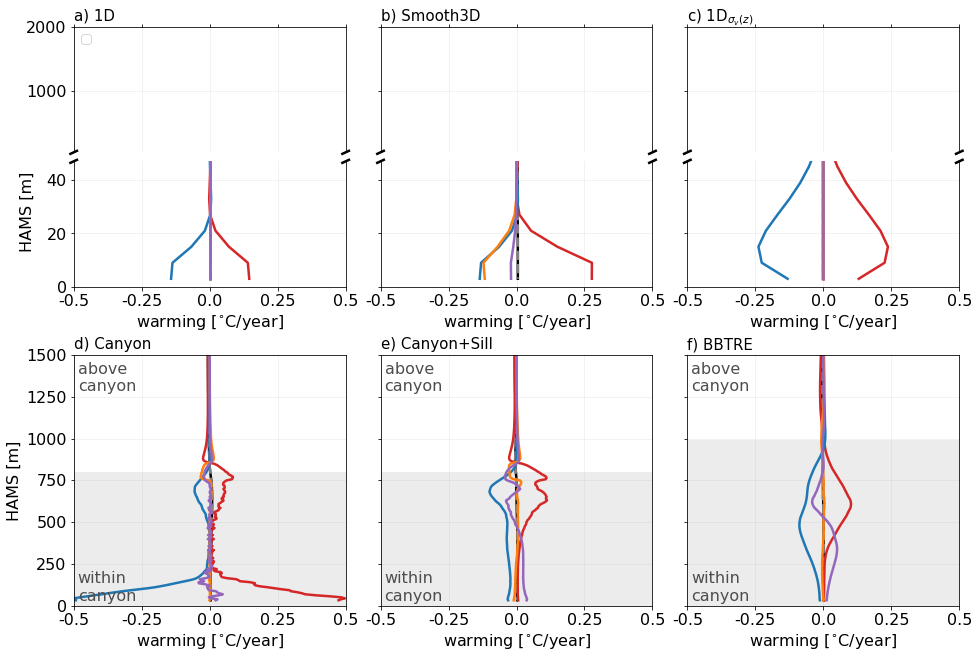

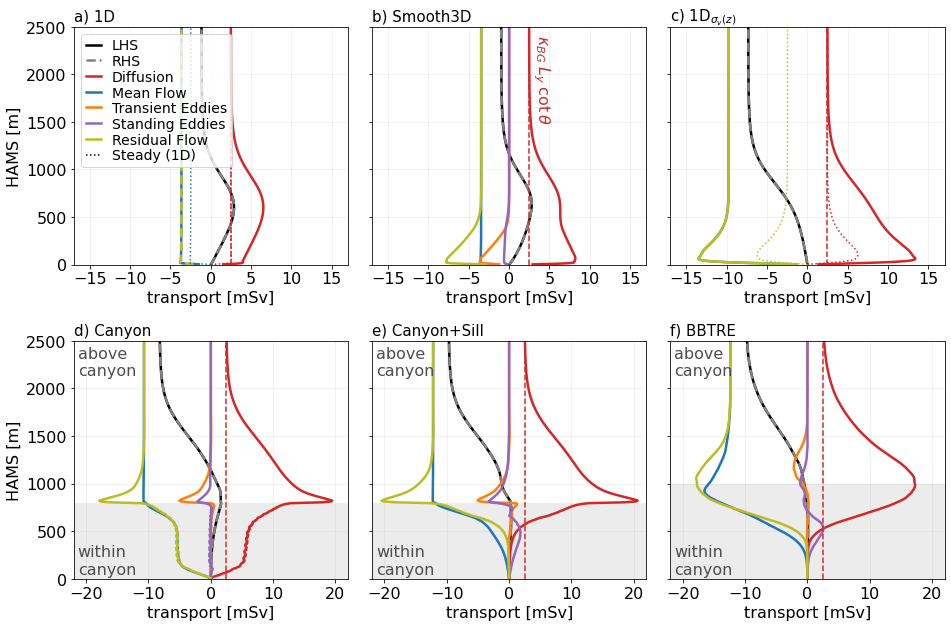

In [71]:
cmap = truncate_colormap(cm.get_cmap('pink'),0.1,1.)

lw = 2.5
nexp = len(experiments)
fig2 = plt.figure(figsize=(13.5,9), constrained_layout=True)
gs = gridspec.GridSpec(ncols=3, nrows=4, figure=fig2)
axes2 = np.array([
    [fig2.add_subplot(gs[0, 0]), fig2.add_subplot(gs[0, 1]), fig2.add_subplot(gs[0, 2])],
    [fig2.add_subplot(gs[2:, 0]), fig2.add_subplot(gs[2:, 1]), fig2.add_subplot(gs[2:, 2])],
    [fig2.add_subplot(gs[1, 0]), fig2.add_subplot(gs[1, 1]), fig2.add_subplot(gs[1, 2])],
])

for ax in axes2[0]:
    ax.spines['bottom'].set_visible(False)
    ax.xaxis.tick_top()
    ax.tick_params(labeltop=False)
for ax in axes2[2]:
    ax.spines['top'].set_visible(False)
    ax.xaxis.tick_bottom()

fig3, axes3 = plt.subplots(2, (nexp+1)//2, figsize=(13.5,9))

plabels=["a)", "b)", "c)", "d)", "e)", "f)"]

longnames = {
    'canyon-tracer': "BBTRE",
    'idealized-sill': "Canyon+Sill",
    'idealized-canyon': "Canyon",
    'idealized-plane': "Smooth3D",
    'idealized-plane-1D': "1D",
    'idealized-plane-1D-Pr': r"1D$_{\sigma_{v}(z)}$"
}

labels = {
    "total_tendency_TH_truth": "LHS",
    "total_tendency_TH": "RHS",
    "diff_tendency_TH": "Diffusion",
    "conv_adv_flux_anom_TH": "Mean Flow",
    "conv_vert_adv_transient_flux_TH": "Transient Eddies",
    "conv_vert_adv_standing_flux_TH": "Standing Eddies",
}

int_labels = {
    "total_tendency_TH_truth": "LHS",
    "total_tendency_TH": "RHS",
    "diff_tendency_TH": "Diffusion",
    "conv_adv_flux_anom_TH": "Mean Flow",
    "conv_vert_adv_transient_flux_TH": "Transient Eddies",
    "conv_vert_adv_standing_flux_TH": "Standing Eddies",
}

linecolors = ["k", "grey", "C3", "C0", "C1", "C4"]
linestyles = ["-", "--",   "-",   "-", "-",  "-"]
    
cutoffs=[50, 50, 50]

for i, (k,v) in enumerate(data.items()):
    print(k, end="\n")

    Lx, Ly = v.XC.size*dx, v.YC.size*dy
    cint = k0*Γ*np.cos(θ)*Ly*Lx
    cbot = k1*Γ*np.cos(θ)*Ly*Lx
    
    for ii, var in enumerate(labels.keys()):
        rolling=1
        if i>2:
            rolling=12
            v[f"{var}_K-per-year"].rolling({"Z": rolling}, center=True).mean().plot(ax=axes2.flatten()[i], y='Z', color=linecolors[ii], label=labels[var], linestyle=linestyles[ii], lw=lw)
        
        elif i<=2:
            v[f"{var}_K-per-year"].plot(ax=axes2.flatten()[i+6], y='Z', color=linecolors[ii], label=labels[var], linestyle=linestyles[ii], lw=lw)
        axes3.flatten()[i].plot([], [], color=linecolors[ii], label=labels[var], linestyle=linestyles[ii], lw=lw)
        if ((i==0)|(i==2)) & ("conv_vert_adv_" in var):
            continue
        v[f"{var}_cumint_mSv"].plot(ax=axes3.flatten()[i], y='Z', color=linecolors[ii], linestyle=linestyles[ii], lw=lw)
        
    axes3.flatten()[i].plot([], [], "C8-", label="Residual Flow", lw=lw)
    tmp_linestyle = linestyles[ii]
    if i==0:
        tmp_linestyle = "--"
    residual = (
        v[f"conv_adv_flux_anom_TH_cumint_mSv"]+
        v[f"conv_vert_adv_transient_flux_TH_cumint_mSv"]+
        v[f"conv_vert_adv_standing_flux_TH_cumint_mSv"]
    )
    residual.plot(ax=axes3.flatten()[i], y='Z', color="C8", linestyle=tmp_linestyle, lw=lw)
            
    if i<=2:
        axes2.flatten()[i].set_xlabel(r"")
        axes2.flatten()[i+6].set_xlabel(r"warming [$^{\circ}$C/year]")
    else:
        axes2.flatten()[i].set_xlabel(r"warming [$^{\circ}$C/year]")
    
    axes2.flatten()[i].set_title(f"{plabels[i]} {longnames[k]}", fontsize=15, loc="left")
    
    axes3.flatten()[i].axvline(cint/(Γ*np.sin(θ)*Lx*Ly)*(Ly_ref*1e-3), linestyle='--', color='C3')
    axes3.flatten()[i].set_xlabel("transport [mSv]")
    axes3.flatten()[i].set_title(f"{plabels[i]} {longnames[k]}", fontsize=15, loc="left")
    if i==1:
        axes3.flatten()[i].annotate(r"$\kappa_{BG}\; L_{y}\; \cot{\theta}$", (0.58, 0.62), xycoords='axes fraction', color="C3", rotation=-90)
    axes2_xticks=np.arange(-0.5, 0.75, 0.25)
    axes2_xticklabels = np.array([-0.5, -0.25, 0, 0.25, 0.5])
    axes2_xlims=np.array([-0.5, 0.5])
    if i<=2:
        axes2.flatten()[i].set_xticks(axes2_xticks)
        axes2.flatten()[i].set_xlim(axes2_xlims)
        axes2.flatten()[i].set_xticklabels([])
        axes2.flatten()[i+6].set_xticks(axes2_xticks)
        axes2.flatten()[i+6].set_xticklabels(axes2_xticklabels)
        axes2.flatten()[i+6].set_xlim(axes2_xlims)
        
        axes3.flatten()[i].set_xticks(np.arange(-15, 20, 5))
        #axes3.flatten()[i].set_xticklabels([-10, None, 0, None, 10])
        axes3.flatten()[i].set_xlim([-17, 17])
    else:
        axes2.flatten()[i].set_xticks(axes2_xticks)
        axes2.flatten()[i].set_xlim(axes2_xlims)
        axes2.flatten()[i].set_xticklabels(axes2_xticklabels)
        #axes2.flatten()[i].set_xticks(axes2_xticks)
        #axes2.flatten()[i].set_xticklabels(np.array([None, -0.1/4, None, 0, None, 0.1/4, None]))
        #axes2.flatten()[i].set_xlim(axes2_xlims/4)
        axes3.flatten()[i].set_xlim([-22, 22])

    if i<=2:
        axes2.flatten()[i].set_ylim(cutoffs[i]+3, 2000)
        axes2.flatten()[i+6].set_ylim(0, cutoffs[i]-3)
    else:
        axes2.flatten()[i].set_ylim(0, 1500)
    axes3.flatten()[i].set_ylim([0, 2500])
    axlist = [axes2.flatten()[i], axes3.flatten()[i]]
    if i<=2: axlist.append(axes2.flatten()[i+6])
    for axi, ax in enumerate(axlist):
        ax.grid(True, alpha=0.2)
        if (i==0) | (i==3):
            ax.set_ylabel("HAMS [m]")
            if (i==0) & (axi<2):
                if axi==1: ax.plot([], [], "k:", label="Steady (1D)")
                ax.legend(loc="upper left", handlelength=1.08, labelspacing=0.12, borderpad=0.35, fontsize=14)
        else:
            ax.set_ylabel("")
            ax.set_yticklabels([])
        ax.fill_between(ax.get_xlim(), [0., 0.], v['crest_HAMS'].values*np.array([1, 1]), lw=5., alpha=0.15, facecolor="grey")
        if i>2:
            ax.annotate("within\ncanyon", xy=(0.015, 0.02), xycoords="axes fraction", color=(0.3, 0.3, 0.3), fontsize=16)
            ax.annotate("above\ncanyon", xy=(0.015, 0.855), xycoords="axes fraction", color=(0.3, 0.3, 0.3), fontsize=16)

ds = bbl1d["steady"]["default"]
ds["k"] = k0+k1*np.exp(-ds['Zl']/h)
ds["kbz_term"] = ds["k"]*ds["bz"]/(N**2 * np.sin(θ))*Ly_ref
ψ_term = -np.cumsum(ds['u'][1:-1]*np.diff(ds['Zl']))*Ly_ref

ax = axes3.flatten()[0]
ax.plot(ds['kbz_term']*1e-3, ds['Zl'], "C3:")
ax.plot(ψ_term*1e-3, ds['Z'][1:-1], "C0:")

ds = bbl1d["steady"]["Pr"]
ds["k"] = k0+k1*np.exp(-ds['Zl']/h)
ds["kbz_term"] = ds["k"]*ds["bz"]/(N**2 * np.sin(θ))*Ly_ref
ψ_term = -np.cumsum(ds['u'][1:-1]*np.diff(ds['Zl']))*Ly_ref
    
ax = axes3.flatten()[2]
ax.plot(ds['kbz_term']*1e-3, ds['Zl'], "C3:")
ax.plot(ψ_term*1e-3, ds['Z'][1:-1], "C8:")
    
for axi, ax in enumerate(axes2[2]):
    ax.set_ylabel("")
    if axi>0: ax.set_yticklabels([])
    
for i in range(0,3):
    break_axes(axes2[0][i], axes2[2][i])
axes2[0][0].set_ylabel("")
axes3[1,0].set_ylabel("HAMS [m]")
fig3.tight_layout()

axes2[2][0].annotate(text="HAMS [m]", xy=(-0.2, 0.3), xycoords="axes fraction", rotation=90)

fig2.savefig(f"../../figures/BBTRE/buoyancy_budget.png", dpi=150., bbox_inches='tight')
fig3.savefig(f"../../figures/BBTRE/integral_buoyancy_budget.png", dpi=150., bbox_inches='tight')

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


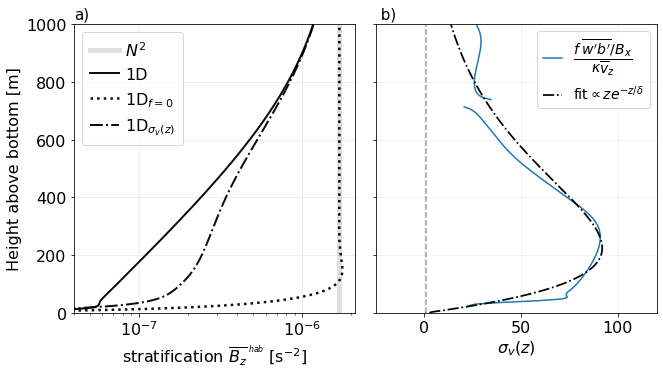

In [72]:
fig, axes = plt.subplots(1, 2, figsize=(9.5, 5.5))

titles = ["Steady 1D models", "1D models at 5000 days", 'Average over full domain', 'Ridge flank average', 'Canyon flanks average', 'Average over canyon trough',]
labels = ['a)', 'b)', 'c)', 'd)', "e)", "f)"]
Nsq_names = ["", "_outside", "_flanks", "_trough"]

ax = axes[0]

ax.axvline(N**2, color="grey", lw=5., alpha=0.25, label=r"$N^{2}$")

steady = bbl_exp(k0, k1, h, N, f, θ)
ax.plot(steady["bz"], steady["zf"], color="k", linestyle='-', label=r"1D", lw=2., alpha=0.95)
steady = bbl_exp(k0, k1, h, N, 0., θ)
ax.plot(steady["bz"], steady["zf"], color="k", linestyle=':', label=r"1D$_{f=0}$", lw=2.5, alpha=0.95)
steady = bbl1d["steady"]["Pr"]
ax.plot(steady["bz"], steady["Zl"], color="k", linestyle='-.', label=r"1D$_{\sigma_{v}(z)}$", lw=2., alpha=0.95)

ticks = np.arange(0., 2.5, 0.5)
ax.set_xticks(ticks*1.e-6)
ax.set_xticklabels(ticks)

ax.set_ylabel("Height above bottom [m]")
ax.legend(loc='upper left', ncol=1, handlelength=1.8, columnspacing=0.4, borderpad=0.5, handletextpad=0.4)

ax.set_xlabel("stratification $\overline{B_{z}}^{\:^{hab}}$ [s$^{-2}$]")
ax.set_ylim(0, 1000)
ax.set_xlim([4e-8, 2.1e-6])
ax.set_xscale('log')
#ax.set_xlim([0, 2.1e-6])
ax.grid(True, alpha=0.25)
ax.set_title("a)", loc='left', fontsize=15)

ax = axes[1]

data_dir = f"../../MITgcm/experiments/rotated_BBTRE_idealized-plane/run/"
Δt = 2*delta_t
ds = open_mdsdataset(data_dir, ignore_unknown_vars=True, prefix=["budgetDiag"], delta_t=Δt)
ds=ds.sel(time=ds['time'])
ds, grid = add_rotated_coords(ds, θ)
ds = ds.reset_coords(['Depth'])
ds['time'] = ds['time'].astype('float64')*1e-9/86400.

vz = grid.diff(ds["VVEL"].mean(["XC", "YG", "time"]), axis="Z", boundary='fill')/grid.diff(ds['Z'], axis="Z", boundary='extend')
kvz = ds["KVDIFF"].mean(["XC", "YC", "time"])*vz

Bx = (N**2*np.sin(θ))
wb = (ds['ADVr_TH']/ds['rA']*g*α).mean(["XC", "YC", "time"])
fwb_bxm = f*wb / Bx

kvz = kvz.where(np.abs(kvz) > 1e-10)
fwb_bxm = fwb_bxm.where(np.abs(fwb_bxm) > 1e-10)

σ = (fwb_bxm/kvz)
σ = σ.where(ds['Zl'] > 20.)
σ.plot(ax=ax, ls="-",y="Zl", lw=1.5, label=r"$\dfrac{f\;\overline{w'b'}/B_{x}}{\kappa \overline{v}_{z}}$")
ax.plot()
ax.set_xlim(-25, 120)
ax.set_ylim(0, 1000)
ax.set_yticklabels([])
ax.set_ylabel("")
ax.set_xlabel(r"$\sigma_{v}(z)$")
ax.set_title(" b)", loc='left', fontsize=15)

import scipy.stats as stats
y1 = stats.gamma.pdf(ds["Z"], a=2, scale=225)
σscale = σ.max().values/np.max(y1)
y1 *= σscale
y1 += 1.
ax.plot(y1, ds['Z'], "k-.", lw=1.75, label=r"fit$\propto z e^{-z/\delta}$")
ax.axvline(1., color="k", alpha=0.4, ls="--")
ax.legend(loc="upper right", fontsize=14, handlelength=1.4)
ax.grid(alpha=0.2)

plt.tight_layout()
plt.savefig(f"../../figures/BBTRE/1d_stratification.png", dpi=150., bbox_inches="tight")

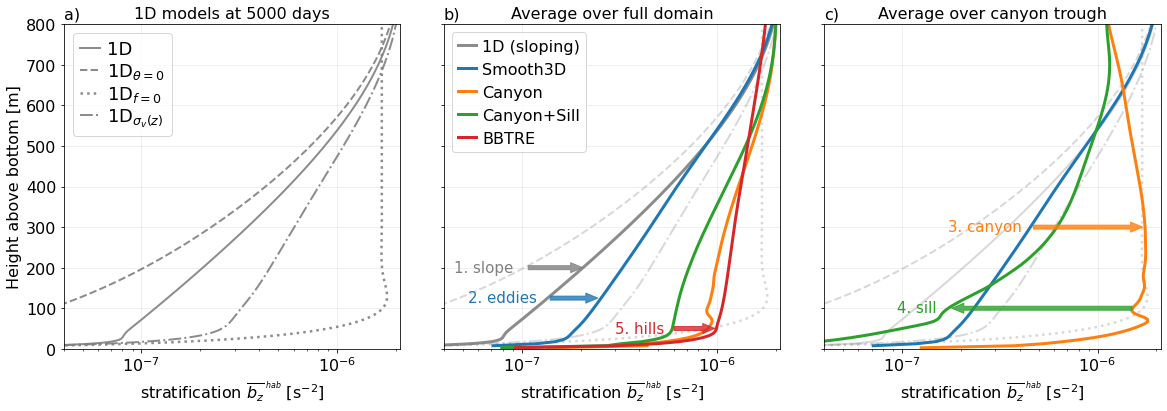

In [73]:
bbl_output = bbl1d['quasi']

fig, axes = plt.subplots(1, 3, figsize=(16.5, 6))

expcolors = {
    'canyon-tracer': "C3",
    'idealized-sill': "C2",
    'idealized-canyon': "C1",
    'idealized-plane': "C0"
}
titles = ["1D models at 5000 days", 'Average over full domain', 'Average over canyon trough',]
labels = ['a)', 'b)', 'c)']
Nsq_names = ["", "_trough"]

ax = axes[0]
bbl_output['default']['bz'].plot(ax=ax, y='Zl', color="grey", linestyle='-', label=r"1D", lw=2., alpha=0.9)
bbl_output['theta=0']['bz'].plot(ax=ax, y='Zl', color="grey", linestyle='--', label=r"1D$_{\theta = 0}$", lw=2., alpha=0.9)
bbl_output['f=0']['bz'].plot(ax=ax, y='Zl', color="grey", linestyle=':', label=r"1D$_{f=0}$", lw=2.5, alpha=0.9)
bbl_output['Pr']['bz'].plot(ax=ax, y='Zl', color="grey", linestyle = '-.', label=r"1D$_{\sigma_{v}(z)}$", lw=2., alpha=0.9)

for i, ax in enumerate(axes[1:]):
    if i!=1:
        bbl_output['default']['bz'].plot(ax=ax, y='Zl', color="grey", linestyle='-', label=r"1D (sloping)", lw=3., alpha=0.9)
    else:
        bbl_output['default']['bz'].plot(ax=ax, y='Zl', color="grey", linestyle='-', label=None, lw=2., alpha=0.3)
    bbl_output['theta=0']['bz'].plot(ax=ax, y='Zl', color="grey", linestyle='--', label=None, lw=2., alpha=0.3)
    bbl_output['f=0']['bz'].plot(ax=ax, y='Zl', color="grey", linestyle=':', label=None, lw=2.5, alpha=0.3)
    bbl_output['Pr']['bz'].plot(ax=ax, y='Zl', color="grey", linestyle = '-.', label=None, lw=2., alpha=0.3)
    for exp in experiments:
        if (exp=='idealized-plane-1D-Pr'): continue
        if (exp=='idealized-plane-1D'): continue
        if (exp=='idealized-plane') & (i>1): continue
        if (exp=='canyon-tracer') & (i==1): continue
        ds = data[exp]
        ds[f'Nsq{Nsq_names[i]}'].plot(ax=ax, y='habC', label=longnames[exp], color=expcolors[exp], lw=3.)
        
for i, ax in enumerate(axes.flatten()):
    ticks = np.arange(0., 2.5, 0.5)
    ax.set_xticks(ticks*1.e-6)
    ax.set_xticklabels(ticks)
    if i==0:
        ax.legend(loc='upper left', ncol=1, handlelength=1.1, columnspacing=0.6, borderpad=0.4, handletextpad=0.4, labelspacing=0.15, fontsize=18)
        ax.set_ylabel("Height above bottom [m]")
    else:
        ax.set_ylabel("")
        ax.set_yticklabels([])

    ax.set_xlabel("stratification $\overline{b_{z}}^{\:^{hab}}$ [s$^{-2}$]")

    ax.set_ylim(0, 800)
    ax.set_xlim([4e-8, 2.1e-6])
    ax.set_xscale('log')
    ax.grid(True, alpha=0.25)
    ax.set_title(titles[i], fontsize=16)
    ax.set_title(labels[i], loc='left', fontsize=16)
    
ax = axes[1]
    
ax.annotate("", xytext=(1.08e-7, 200), xy=(2.05e-7, 200), arrowprops=dict(edgecolor="grey", facecolor="grey", headwidth=10., alpha=0.8))
ax.text(0.45e-7, 189, "1. slope", color="grey", fontsize=15)

ax.annotate("", xytext=(1.4e-7, 125), xy=(2.45e-7, 125), arrowprops=dict(edgecolor="C0", facecolor="C0", headwidth=10., alpha=0.8))
ax.text(0.53e-7, 114, "2. eddies", color="C0", fontsize=15)
  
ax.annotate("", xytext=(6e-7, 50), xy=(0.97e-6, 50), arrowprops=dict(edgecolor="C3", facecolor="C3", headwidth=10., alpha=0.8))
ax.text(3e-7, 39, "5. hills", color="C3", fontsize=15)

ax.legend(loc='upper left', ncol=1, handlelength=1.1, columnspacing=0.6, borderpad=0.4, handletextpad=0.4)

ax = axes[2]
    
ax.annotate("", xytext=(4.7e-7, 300), xy=(1.7e-6, 300), arrowprops=dict(edgecolor="C1", facecolor="C1", headwidth=10., alpha=0.8))
ax.text(1.72e-7, 290, "3. canyon", color="C1", fontsize=15)

ax.annotate("", xytext=(1.5e-6, 100), xy=(1.8e-7, 100), arrowprops=dict(edgecolor="C2", facecolor="C2", headwidth=10., alpha=0.8))
ax.text(0.95e-7, 90, "4. sill", color="C2", fontsize=15)


plt.tight_layout(w_pad=2.5)
plt.savefig(f"../../figures/BBTRE/hab_stratification.png", dpi=150., bbox_inches="tight")